## Bibliotecas

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.io import imread,imsave,imshow
from skimage.color import rgb2gray
from scipy.stats import norm, kurtosis, entropy, skew
from skimage.feature import graycoprops,graycomatrix
import cv2
from glob import glob
import os
import csv
import plotly.express as px
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier as mlp
from sklearn.metrics import accuracy_score as acc
from sklearn.model_selection import cross_val_score # Cross Validation Function.
from sklearn.model_selection import KFold # KFold Class.
from sklearn.linear_model import LinearRegression # Linear Regression class.
from skimage.exposure import histogram
import tqdm
from sklearn.svm import SVC
import xgboost as xgb
import seaborn as sns

#### Os seguintes valores são calculado com o histograma e são largamente utilizados para representar imagens:

- Média 
- Variância 
- Skewness 
- Kurtosis 
- Energia 
- Entropia 

---
## Leitura da Imagem

In [5]:
# resolução das imagens
altura = 240
largura = 240

In [6]:
def Ler_Cinza(imagem):
    # Função para realizar a leitura de uma imagem e retornar a imagem cinza.
    img = cv2.imread(imagem,0)
    return img, cv2.resize(img, (largura, altura))

---
## Histograma e Estatísticas

In [8]:
def Retorna_Histograma(Imagem):  
    # Função para retornar o histograma de uma imagem.
    Linhas, Colunas = Imagem.shape
    Array = []
    Valores = []
    for I in range(256):
        Array.append(0)
        Valores.append(I)
    for L in range(Linhas):
        for C in range(Colunas):
            # print(Imagem[L][C])
            Array[int(Imagem[L][C])] += 1   
    return [Array,Valores]

In [9]:
def Descritor_Histograma(imagem):
    Histograma = Retorna_Histograma(imagem)
    histograma2 = histogram(imagem, nbins=256)

    media = np.mean(histograma2[0])
    variancia = np.var(Histograma[0])
    s = skew(Histograma[0])
    kur = kurtosis(Histograma[0])
    good = graycomatrix(imagem,[0],[0]) # Energia
    ener = graycoprops(good,'energy')
    ent = entropy(Histograma[0])
    return {
        'histograma': Histograma[0], 
        'media': media, 
        'var': variancia,
        'skewness': s, 
        'kurtosis': kur, 
        'energy': ener[0][0], 
        'entropy': ent}

In [10]:
print(Descritor_Histograma(cinza))

{'histograma': [97, 18, 26, 25, 27, 37, 27, 35, 28, 61, 89, 142, 227, 145, 148, 177, 222, 334, 421, 480, 568, 590, 571, 630, 663, 605, 605, 651, 657, 709, 859, 1018, 930, 928, 1013, 925, 957, 956, 940, 962, 1036, 871, 756, 606, 598, 648, 612, 592, 532, 521, 526, 481, 530, 563, 543, 542, 540, 503, 447, 419, 461, 372, 422, 380, 375, 348, 287, 277, 257, 255, 220, 230, 274, 274, 275, 318, 294, 259, 270, 216, 173, 168, 164, 147, 191, 158, 135, 162, 167, 150, 155, 151, 123, 133, 147, 146, 124, 123, 139, 117, 142, 121, 141, 151, 128, 114, 129, 138, 123, 123, 113, 127, 117, 115, 95, 107, 116, 103, 109, 109, 112, 120, 116, 111, 99, 123, 96, 102, 131, 135, 123, 123, 119, 141, 137, 119, 153, 160, 177, 205, 243, 217, 235, 247, 208, 188, 183, 171, 171, 151, 183, 188, 184, 198, 189, 188, 171, 157, 167, 137, 149, 146, 148, 114, 113, 132, 168, 129, 121, 154, 157, 139, 115, 147, 104, 130, 120, 133, 128, 130, 131, 133, 124, 119, 131, 132, 130, 135, 137, 139, 132, 158, 140, 133, 169, 142, 157, 171, 172, 

---
## Leitura do DataSet

In [11]:
def contabilizaTamanhos(dataset):
    tamanhos = {'total': 0}
    for classe in dataset:
        tamanhos[classe] = len(dataset[classe])
        tamanhos['total'] += len(dataset[classe])
    dataset['tamanhos'] = tamanhos
    return dataset

In [12]:
def lerDataset(nameDataset):
    dataset = {}
    for classe in os.listdir(nameDataset):
        dataset[classe] = glob(f'flowers/{classe}/*', recursive=True)

    dataset = contabilizaTamanhos(dataset)
    
    return dataset

In [13]:
dataset = lerDataset('flowers')

In [14]:
dataset['tamanhos']

{'total': 4317,
 'daisy': 764,
 'sunflower': 733,
 'tulip': 984,
 'rose': 784,
 'dandelion': 1052}

In [15]:
dataset['daisy'][0:10] # Não preciso abrir todas as imagens, apenas ter os endereços para abrir quando precisar.

['flowers/daisy/14021430525_e06baf93a9.jpg',
 'flowers/daisy/16020253176_60f2a6a5ca_n.jpg',
 'flowers/daisy/7133935763_82b17c8e1b_n.jpg',
 'flowers/daisy/9515186037_3be48fe68f.jpg',
 'flowers/daisy/15327813273_06cdf42210.jpg',
 'flowers/daisy/3285641623_da0e47f49a.jpg',
 'flowers/daisy/9299302012_958c70564c_n.jpg',
 'flowers/daisy/8071646795_2fdc89ab7a_n.jpg',
 'flowers/daisy/5885826924_38fdc6bcaa_n.jpg',
 'flowers/daisy/5512287917_9f5d3f0f98_n.jpg']

In [16]:
imgTesteBlack, redimensionadA = Ler_Cinza(dataset['daisy'][5])

In [19]:
imgTesteBlack

array([[86, 83, 81, ..., 45, 49, 52],
       [84, 81, 80, ..., 51, 52, 52],
       [80, 79, 77, ..., 52, 53, 53],
       ...,
       [34, 37, 37, ..., 26, 26, 26],
       [34, 34, 34, ..., 24, 23, 23],
       [33, 32, 33, ..., 25, 24, 24]], dtype=uint8)

In [20]:
Descritor_Histograma(imgTesteBlack)

{'histograma': [3,
  2,
  4,
  4,
  2,
  8,
  5,
  16,
  21,
  23,
  35,
  34,
  46,
  55,
  72,
  131,
  241,
  478,
  719,
  855,
  894,
  950,
  938,
  1081,
  1061,
  1092,
  1094,
  1092,
  970,
  1000,
  943,
  923,
  918,
  887,
  977,
  859,
  881,
  803,
  825,
  860,
  841,
  835,
  812,
  772,
  753,
  754,
  712,
  659,
  665,
  686,
  690,
  717,
  638,
  685,
  613,
  606,
  639,
  591,
  609,
  616,
  581,
  601,
  640,
  695,
  679,
  718,
  794,
  841,
  954,
  913,
  939,
  906,
  877,
  832,
  823,
  809,
  725,
  696,
  688,
  658,
  617,
  630,
  557,
  559,
  560,
  567,
  587,
  585,
  578,
  527,
  475,
  472,
  425,
  419,
  422,
  427,
  414,
  380,
  354,
  333,
  311,
  266,
  241,
  224,
  208,
  204,
  185,
  169,
  158,
  182,
  165,
  179,
  190,
  177,
  206,
  181,
  188,
  173,
  187,
  204,
  200,
  233,
  248,
  228,
  199,
  219,
  233,
  232,
  244,
  230,
  247,
  246,
  226,
  233,
  229,
  268,
  237,
  261,
  240,
  280,
  266,
  265,
  245,
 

---
## Criação da Matriz com os atributos calculados

In [21]:
def criaLinhaCsv(d, arquivo='matriz.csv'):
    # ordem: nomeArq,largura,altura,media,variancia,skewness,kurtosis,energy,entropy,className,classId
    linha = [d['img'], d['largura'], d['altura'], d['media'], d['var'], d['skewness'], d['kurtosis'], d['energy'], d['entropy'], d['classe'], d['classeId']]
    
    with open(arquivo, 'a') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerow(linha)

In [22]:
def criaMatriz(dataset, arquivo):
    matriz = []
    count = 0
    for index, classe in enumerate(dataset):
        print(f'Inserindo dados da classe {index} referente as {classe}')
        for img in dataset[classe]:
            if count < 4317:
                imagem, imgRedim = Ler_Cinza(img)
                descritor = Descritor_Histograma(imgRedim)
                descritor['classe'] = classe
                descritor['img'] = img
                descritor['classeId'] = index
                descritor['largura'], descritor['altura'] = imgRedim.shape

                criaLinhaCsv(descritor, arquivo)
                count += 1

In [23]:
# Função que cria a matriz. Não vou executar pelo o tempo.
#criaMatriz(dataset, 'matriz2.csv')

In [24]:
matriz = pd.read_csv('matriz2.csv')

In [25]:
matriz

,nomeArq,largura,altura,media,variancia,skewness,kurtosis,energy,entropy,className,classId
0,flowers/daisy/14021430525_e06baf93a9.jpg,240,240,229.482072,5.201105e+04,0.899909,-0.600774,0.088991,5.046967,daisy,0
1,flowers/daisy/16020253176_60f2a6a5ca_n.jpg,240,240,232.258065,6.599149e+04,1.217197,0.341232,0.094859,4.938162,daisy,0
2,flowers/daisy/7133935763_82b17c8e1b_n.jpg,240,240,225.000000,6.158387e+06,15.747844,247.560511,0.692164,2.022297,daisy,0
3,flowers/daisy/9515186037_3be48fe68f.jpg,240,240,225.000000,9.255158e+04,1.186620,-0.123340,0.105107,4.710460,daisy,0
4,flowers/daisy/15327813273_06cdf42210.jpg,240,240,238.016529,3.797228e+04,1.306960,1.009875,0.082681,5.190056,daisy,0
...,...,...,...,...,...,...,...,...,...,...,...
4312,flowers/dandelion/14053173516_a00150a919_m.jpg,240,240,247.210300,1.981962e+04,-0.134134,-1.084269,0.073726,5.289232,dandelion,4
4313,flowers/dandelion/16242239484_51286673af.jpg,240,240,293.877551,7.173307e+04,1.127515,1.025015,0.097166,4.793789,dandelion,4
4314,flowers/dandelion/2076141453_c63801962a_m.jpg,240,240,227.667984,4.754916e+04,1.499099,2.621634,0.087035,5.107898,dandelion,4
4315,flowers/dandelion/3021333497_b927cd8596.jpg,240,240,225.882353,1.926077e+06,15.785531,248.451103,0.390542,3.905978,dandelion,4


---
## Scatter Plot
Os gráficos de dispersão ou Scatter plot são representações gráficas do relacionamento entre duas variáveis numéricas. O Scatter plot utiliza pontos para representar essa relação, cada ponto representa o valor de uma variável no eixo horizontal e o valor de outra variável no eixo vertical.

Fonte: https://www.flai.com.br/juscudilio/scatter-plot-um-guia-completo-para-graficos-de-dispersao/

In [3]:
matriz = pd.read_csv('matriz2.csv')

In [4]:
matriz.keys()

Index(['nomeArq', 'largura', 'altura', 'media', 'variancia', 'skewness',
       'kurtosis', 'energy', 'entropy', 'className', 'classId'],
      dtype='object')

In [5]:
def manyShow(*imgs, color=None):
    _, ax = plt.subplots(1, len(imgs), figsize=(20, 20),sharex=True)
    for index, i in enumerate(ax):
        i.imshow(imgs[index], cmap=color)
        i.set_title(f'{imgs[index].shape}')
        i.axis('off')

In [6]:
def manyShowWithTitle(*imgs, color=None):
    _, ax = plt.subplots(1, len(imgs), figsize=(20, 20),sharex=True)
    for index, i in enumerate(ax):
        i.imshow(imgs[index]['img'], cmap=color)
        i.set_title(f'{imgs[index]["title"]} \n {imgs[index]["img"].shape}')
        i.axis('off')

In [13]:
def scatterMostra(matriz, xlabel, ylabel, color='red'):
    sns.scatterplot(x=matriz[xlabel], y=matriz[ylabel], hue=matriz['className'])
    plt.title(f'{xlabel} x {ylabel}')
    plt.show()

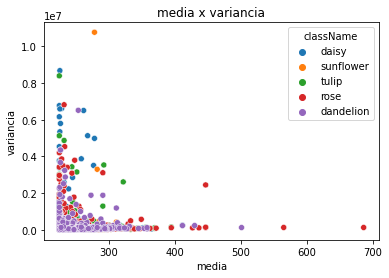

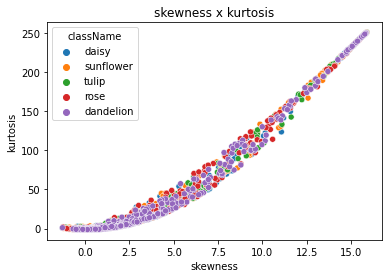

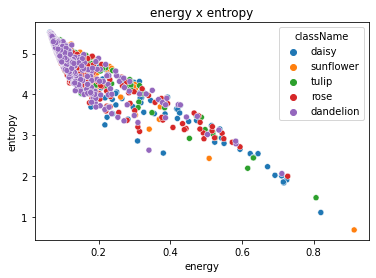

In [14]:
scatterMostra(matriz, 'media', 'variancia')
scatterMostra(matriz, 'skewness', 'kurtosis')
scatterMostra(matriz, 'energy', 'entropy')

In [ ]:
atributos = [ ['media', 'variancia'], ['skewness', 'kurtosis'], [ 'energy', 'entropy'] ]
# scatter plot with matplotlib

In [ ]:
plt.scatter(matriz[atributos[1][0]], matriz[atributos[1][1]])

In [ ]:
plt.scatter(matriz[atributos[2][0]], matriz[atributos[2][1]])

In [28]:
def plotaScatter(matriz, x, y, tamanho=400, titulo="Scatter Plot", xLabel="X", yLabel="Y"):
    fig  = px.scatter(matriz, x=x, y =y, log_x = True, width=tamanho+300, height=tamanho)
    fig.update_traces(marker = dict(size = 4, line=dict(width = 2)), selector = dict(mode = 'markers'))
    fig.update_layout(title = titulo)
    fig.update_xaxes(title = xLabel)
    fig.update_yaxes(title = yLabel)
    fig.show()

---
## Classificação

In [52]:
def classification(X,y):

    """
    X é uma matriz onde cada linha corresponde aos atributos calculados com o descritor
    y são os rótulos da classe de cada imagem. Exemplo [0,1,0,0,1,2,2,0,0,0,...,1]
    """
    
    # separar conjuntos de treino e teste
    X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,shuffle=True, random_state=42)
    # criar instancia do classificador
    clf = mlp()
    # treinar o classificador
    clf.fit(X_train,y_train)
    # realizar a predicao
    pred = clf.predict(X_test)
    # calcular o resultado utilizando a acuracia
    acuracia = acc(y_test,pred)
    
    return acuracia

In [53]:
def classificationForest(X,y):

    
    """ com random forest """

    # separar conjuntos de treino e teste
    X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,shuffle=True, random_state=42)
    # criar instancia do classificador
    clf = rfc()
    # treinar o classificador
    clf.fit(X_train,y_train)
    # realizar a predicao
    pred = clf.predict(X_test)
    # calcular o resultado utilizando a acuracia
    acuracia = acc(y_test,pred)
    


    return acuracia

In [69]:
def classificationSVM(X, y):
    svc = SVC(gamma="auto")
    #cv_result = cross_val_score(svc, X, y, cv=10, scoring="accuracy")

    X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,shuffle=True)
    # criar instancia do classificador
    clf = svc
    # treinar o classificador
    clf.fit(X_train,y_train)
    # realizar a predicao
    pred = clf.predict(X_test)
    # calcular o resultado utilizando a acuracia
    acuracia = acc(y_test,pred)


    return acuracia


In [80]:
def classificationXBR(X, y):
    X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,shuffle=True)
    # criar instancia do classificador
    clf = xgb.XGBClassifier()
    # treinar o classificador
    clf.fit(X_train,y_train)
    # realizar a predicao
    pred = clf.predict(X_test)
    # calcular o resultado utilizando a acuracia
    acuracia = acc(y_test,pred)

    return acuracia
    

In [32]:
print(
    list(matriz.keys()).index('media'),
    list(matriz.keys()).index('variancia'),
    list(matriz.keys()).index('skewness'),
    list(matriz.keys()).index('kurtosis'),
    list(matriz.keys()).index('energy'),
    list(matriz.keys()).index('entropy'),
    list(matriz.keys()).index('classId')
)

3 4 5 6 7 8 10


In [33]:
# cria um array normal com os dados: media, variancia, skewness, kurtosis, energy, entropy
def pegaMatrizAux(matriz):
    atual = 0
    cont = 733
    aux = []
    y = []
    for i in matriz.values:
        n = list(i)
        if n[10] == atual:
            aux.append([n[3], n[4], n[5], n[6], n[7], n[8]])
            y.append(n[10])
            cont -= 1
        
        if cont == 0:
            atual += 1
            cont = 733

    return aux, y

In [34]:
aux, y = pegaMatrizAux(matriz)

In [54]:
f"Acuracia MLP: {(classification(aux, y)* 100)} %"

'Acuracia MLP: 19.508867667121418 %'

In [36]:
f"Acuracia RandomForest: {(classificationForest(aux, y) * 100)} %"

'Acuracia RandomForest: 25.517993456924753 %'

In [77]:
f"Acuracia SVM: {(classificationSVM(aux, y) * 100)} %"

'Acuracia SVM: 18.454545454545453 %'

In [81]:
f"Acuracia XBR: {(classificationXBR(aux, y) * 100)} %"

'Acuracia XBR: 24.09090909090909 %'

In [82]:
def pegaMelhores(aux, y, qnt):
    resultadosMLP = []
    resultadosRF = []
    resultadosSVM = []
    resultadosXBR = []
    for i in tqdm.tqdm(range(qnt)):
        resultadosMLP.append(classification(aux, y))
        resultadosRF.append(classificationForest(aux, y))
        resultadosSVM.append(classificationSVM(aux, y))
        resultadosXBR.append(classificationXBR(aux, y))
        
    return resultadosMLP, resultadosRF, resultadosSVM, resultadosXBR

In [83]:
melhoresMLP, melhoresRF, melhoresSVM, melhoresXBR = pegaMelhores(aux, y, 20)

100%|██████████| 20/20 [00:48<00:00,  2.41s/it]


In [87]:
print(f'Melhores: \n\t MLP: {max(melhoresMLP)} \n\t RF: {max(melhoresRF)} \n\t SVM: {max(melhoresSVM)} \n\t XBR: {max(melhoresXBR)}')


Melhores: 
	 MLP: 0.25102319236016374 
	 RF: 0.2595419847328244 
	 SVM: 0.20272727272727273 
	 XBR: 0.27545454545454545


In [88]:
print(f'Média: \n\t MLP: {np.mean(melhoresMLP)} \n\t RF: {np.mean(melhoresRF)} \n\t SVM: {np.mean(melhoresSVM)} \n\t XBR: {np.mean(melhoresXBR)}')

Média: 
	 MLP: 0.2140518417462483 
	 RF: 0.2483642311886587 
	 SVM: 0.1895909090909091 
	 XBR: 0.2514090909090909


In [89]:
print(f'Piores: \n\t MLP: {min(melhoresMLP)} \n\t RF: {min(melhoresRF)} \n\t SVM: {min(melhoresSVM)} \n\t XBR: {min(melhoresXBR)}')

Piores: 
	 MLP: 0.19236016371077763 
	 RF: 0.23773173391494 
	 SVM: 0.1781818181818182 
	 XBR: 0.2318181818181818
